In [1]:
import torch
from transformers import BertTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments

# Replace these lists with your actual dataset
# sentences = ["This is an example sentence from my domain.", "Another example sentence from my domain."]
from utils import load_train_eval_data

# Among the original training data, 75% is used for training, 25% is used for validation
train_prop = 0.75

# Set the fine-tuning type 
train_type = "poems" # One of ["sonnets", "shakestrain", "poems"]

train_set, val_set = load_train_eval_data(train_type, train_prop)





continue_with_checkpoint = True

# if continue_with_checkpoint: 
#     checkpoint_iter = 15300 # Change this to change which checkpoint to load
#     num_remaining_epochs = 4
#     # Load the tokenizer and the pre-trained model
#     tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#     model = BertForMaskedLM.from_pretrained(f"./results_prev/checkpoint-{checkpoint_iter}/")

#     # Set up the data collator
#     data_collator = DataCollatorForLanguageModeling(
#         tokenizer=tokenizer, mlm=True, mlm_probability=0.15
#     )
#     training_args = torch.load(f"./results_prev/checkpoint-{checkpoint_iter}/training_args.bin"),
#     print(list(training_args))
    
    
#     STOP
    
#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_set,
#         eval_dataset=val_set,
#         data_collator=data_collator,
#     )
# else:
# Load the tokenizer and the pre-trained model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForMaskedLM.from_pretrained("bert-base-uncased")

# Set up the data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

# Set up the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    num_train_epochs=6,
    per_device_train_batch_size=200,
    logging_dir="./logs",
    logging_steps=1,
    save_steps=100,
    seed=42,
    learning_rate=2e-5,
    weight_decay=0.01,
)

# Create the Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=val_set,
    data_collator=data_collator,
)

    
    
    
    
# Fine-tune the model
if continue_with_checkpoint:
    checkpoint_iter = 77100 # Change this to change which checkpoint to load
    trainer.train(f"./results/checkpoint-{checkpoint_iter}/")
else:
    trainer.train()

torch.save(model, "model.pth")

Found cached dataset text (C:/Users/Shaobo Liang/.cache/huggingface/datasets/text/default-6e1d81cb2f8ed1f2/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\Shaobo Liang\.cache\huggingface\datasets\text\default-6e1d81cb2f8ed1f2\0.0.0\cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2\cache-99d207b93f1b0cb6.arrow
Loading cached processed dataset at C:\Users\Shaobo Liang\.cache\huggingface\datasets\text\default-6e1d81cb2f8ed1f2\0.0.0\cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2\cache-5e8db537b41adb9e.arrow
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceC

  0%|          | 0/10505 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss
6,2.423900,2.618902


In [2]:
output_dir = "./saved_model"
model.save_pretrained(output_dir)

In [3]:
from test import test_main

acc_arr = []
cos_arr = []

# model_path = "model.pth"
# model_path = "./results/checkpoint-1000/"
model_path = "./saved_model/"

k = 5 # I want top 5 test metrics

results_dict = test_main(model_path, k)

print(f"Top {k} accuracy is {results_dict['accuracy']}.")
print(f"Top {k} cosine similarity score is {results_dict['cos_sim']}.")
# print(f"Top {k} rhyming score is {results_dict["rhyme"]}.") # To be implemented

save_steps = 100
num_saved_models = 800
for i in range(num_saved_models):
    model_path = f"./results/checkpoint-{100 * (i + 1)}/"

    k = 5 # I want top 5 test metrics

    results_dict = test_main(model_path, k)

    print(f"Checkpoint {100 * (i+1)}")
    print(f"Top {k} accuracy is {results_dict['accuracy']}.")
    print(f"Top {k} cosine similarity score is {results_dict['cos_sim']}.")
    
    acc_arr.append(results_dict['accuracy'])
    cos_arr.append(results_dict['cos_sim'])
    


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'accuracy': 0.10455764075067024, 'cos_sim': tensor(0.3744)}
Top 5 accuracy is 0.1742627345844504.
Top 5 cosine similarity score is 0.4368213415145874.
Checkpoint 100
Top 5 accuracy is 0.0938337801608579.
Top 5 cosine similarity score is 0.360139936208725.
Checkpoint 200
Top 5 accuracy is 0.10455764075067024.
Top 5 cosine similarity score is 0.377137690782547.
Checkpoint 300
Top 5 accuracy is 0.09919571045576407.
Top 5 cosine similarity score is 0.3670937418937683.
Checkpoint 400
Top 5 accuracy is 0.09651474530831099.
Top 5 cosine similarity score is 0.3703499436378479.
Checkpoint 500
Top 5 accuracy is 0.10187667560321716.
Top 5 cosine similarity score is 0.36577752232551575.
Checkpoint 600
Top 5 accuracy is 0.09919571045576407.
Top 5 cosine similarity score is 0.37025949358940125.
Checkpoint 700
Top 5 accuracy is 0.10723860589812333.
Top 5 cosine similarity score is 0.383323073387146.
Checkpoint 800
Top 5 accuracy is 0.10455764075067024.
Top 5 cosine similarity score is 0.381119072437

Checkpoint 7600
Top 5 accuracy is 0.12332439678284182.
Top 5 cosine similarity score is 0.39910879731178284.
Checkpoint 7700
Top 5 accuracy is 0.11796246648793565.
Top 5 cosine similarity score is 0.39223363995552063.
Checkpoint 7800
Top 5 accuracy is 0.11796246648793565.
Top 5 cosine similarity score is 0.3904249966144562.
Checkpoint 7900
Top 5 accuracy is 0.11796246648793565.
Top 5 cosine similarity score is 0.3949600160121918.
Checkpoint 8000
Top 5 accuracy is 0.12332439678284182.
Top 5 cosine similarity score is 0.3894812762737274.
Checkpoint 8100
Top 5 accuracy is 0.12332439678284182.
Top 5 cosine similarity score is 0.39409491419792175.
Checkpoint 8200
Top 5 accuracy is 0.13136729222520108.
Top 5 cosine similarity score is 0.40598657727241516.
Checkpoint 8300
Top 5 accuracy is 0.1260053619302949.
Top 5 cosine similarity score is 0.4018014967441559.
Checkpoint 8400
Top 5 accuracy is 0.1260053619302949.
Top 5 cosine similarity score is 0.39674651622772217.
Checkpoint 8500
Top 5 acc

Checkpoint 15200
Top 5 accuracy is 0.14209115281501342.
Top 5 cosine similarity score is 0.41165250539779663.
Checkpoint 15300
Top 5 accuracy is 0.13404825737265416.
Top 5 cosine similarity score is 0.40591269731521606.
Checkpoint 15400
Top 5 accuracy is 0.14745308310991956.
Top 5 cosine similarity score is 0.41594913601875305.
Checkpoint 15500
Top 5 accuracy is 0.13672922252010725.
Top 5 cosine similarity score is 0.4046606421470642.
Checkpoint 15600
Top 5 accuracy is 0.14745308310991956.
Top 5 cosine similarity score is 0.40988561511039734.
Checkpoint 15700
Top 5 accuracy is 0.1447721179624665.
Top 5 cosine similarity score is 0.41283488273620605.
Checkpoint 15800
Top 5 accuracy is 0.14745308310991956.
Top 5 cosine similarity score is 0.41262155771255493.
Checkpoint 15900
Top 5 accuracy is 0.13941018766756033.
Top 5 cosine similarity score is 0.41170331835746765.
Checkpoint 16000
Top 5 accuracy is 0.1447721179624665.
Top 5 cosine similarity score is 0.4087347388267517.
Checkpoint 161

Checkpoint 22800
Top 5 accuracy is 0.15013404825737264.
Top 5 cosine similarity score is 0.41951853036880493.
Checkpoint 22900
Top 5 accuracy is 0.1447721179624665.
Top 5 cosine similarity score is 0.41490787267684937.
Checkpoint 23000
Top 5 accuracy is 0.15013404825737264.
Top 5 cosine similarity score is 0.41614338755607605.
Checkpoint 23100
Top 5 accuracy is 0.1581769436997319.
Top 5 cosine similarity score is 0.42132115364074707.
Checkpoint 23200
Top 5 accuracy is 0.15281501340482573.
Top 5 cosine similarity score is 0.4183855652809143.
Checkpoint 23300
Top 5 accuracy is 0.1447721179624665.
Top 5 cosine similarity score is 0.41187426447868347.
Checkpoint 23400
Top 5 accuracy is 0.14209115281501342.
Top 5 cosine similarity score is 0.41091641783714294.
Checkpoint 23500
Top 5 accuracy is 0.15013404825737264.
Top 5 cosine similarity score is 0.4165486991405487.
Checkpoint 23600
Top 5 accuracy is 0.1447721179624665.
Top 5 cosine similarity score is 0.4088381826877594.
Checkpoint 23700


Checkpoint 30400
Top 5 accuracy is 0.15281501340482573.
Top 5 cosine similarity score is 0.4185994267463684.
Checkpoint 30500
Top 5 accuracy is 0.1581769436997319.
Top 5 cosine similarity score is 0.4204835891723633.
Checkpoint 30600
Top 5 accuracy is 0.1581769436997319.
Top 5 cosine similarity score is 0.4211803674697876.
Checkpoint 30700
Top 5 accuracy is 0.1581769436997319.
Top 5 cosine similarity score is 0.42393890023231506.
Checkpoint 30800
Top 5 accuracy is 0.1581769436997319.
Top 5 cosine similarity score is 0.42200687527656555.
Checkpoint 30900
Top 5 accuracy is 0.16085790884718498.
Top 5 cosine similarity score is 0.42598026990890503.
Checkpoint 31000
Top 5 accuracy is 0.15281501340482573.
Top 5 cosine similarity score is 0.4185364246368408.
Checkpoint 31100
Top 5 accuracy is 0.16085790884718498.
Top 5 cosine similarity score is 0.4243934750556946.
Checkpoint 31200
Top 5 accuracy is 0.1554959785522788.
Top 5 cosine similarity score is 0.4238351881504059.
Checkpoint 31300
Top 

Checkpoint 38000
Top 5 accuracy is 0.1581769436997319.
Top 5 cosine similarity score is 0.42512768507003784.
Checkpoint 38100
Top 5 accuracy is 0.16085790884718498.
Top 5 cosine similarity score is 0.4262855350971222.
Checkpoint 38200
Top 5 accuracy is 0.16353887399463807.
Top 5 cosine similarity score is 0.4281511604785919.
Checkpoint 38300
Top 5 accuracy is 0.16085790884718498.
Top 5 cosine similarity score is 0.42748069763183594.
Checkpoint 38400
Top 5 accuracy is 0.1554959785522788.
Top 5 cosine similarity score is 0.4243707060813904.
Checkpoint 38500
Top 5 accuracy is 0.1554959785522788.
Top 5 cosine similarity score is 0.4248330891132355.
Checkpoint 38600
Top 5 accuracy is 0.16085790884718498.
Top 5 cosine similarity score is 0.4247998595237732.
Checkpoint 38700
Top 5 accuracy is 0.16085790884718498.
Top 5 cosine similarity score is 0.4244914650917053.
Checkpoint 38800
Top 5 accuracy is 0.16085790884718498.
Top 5 cosine similarity score is 0.42426928877830505.
Checkpoint 38900
To

Checkpoint 45600
Top 5 accuracy is 0.17158176943699732.
Top 5 cosine similarity score is 0.4333163797855377.
Checkpoint 45700
Top 5 accuracy is 0.16890080428954424.
Top 5 cosine similarity score is 0.43136465549468994.
Checkpoint 45800
Top 5 accuracy is 0.16085790884718498.
Top 5 cosine similarity score is 0.42318201065063477.
Checkpoint 45900
Top 5 accuracy is 0.17158176943699732.
Top 5 cosine similarity score is 0.43359681963920593.
Checkpoint 46000
Top 5 accuracy is 0.16621983914209115.
Top 5 cosine similarity score is 0.43036532402038574.
Checkpoint 46100
Top 5 accuracy is 0.16890080428954424.
Top 5 cosine similarity score is 0.4312972128391266.
Checkpoint 46200
Top 5 accuracy is 0.1742627345844504.
Top 5 cosine similarity score is 0.43594712018966675.
Checkpoint 46300
Top 5 accuracy is 0.1581769436997319.
Top 5 cosine similarity score is 0.4233018457889557.
Checkpoint 46400
Top 5 accuracy is 0.16890080428954424.
Top 5 cosine similarity score is 0.43191802501678467.
Checkpoint 4650

Checkpoint 53200
Top 5 accuracy is 0.16353887399463807.
Top 5 cosine similarity score is 0.4285808503627777.
Checkpoint 53300
Top 5 accuracy is 0.1581769436997319.
Top 5 cosine similarity score is 0.42463454604148865.
Checkpoint 53400
Top 5 accuracy is 0.1581769436997319.
Top 5 cosine similarity score is 0.4241180419921875.
Checkpoint 53500
Top 5 accuracy is 0.16353887399463807.
Top 5 cosine similarity score is 0.4300946891307831.
Checkpoint 53600
Top 5 accuracy is 0.16353887399463807.
Top 5 cosine similarity score is 0.42620572447776794.
Checkpoint 53700
Top 5 accuracy is 0.16621983914209115.
Top 5 cosine similarity score is 0.4311736226081848.
Checkpoint 53800
Top 5 accuracy is 0.16353887399463807.
Top 5 cosine similarity score is 0.42699724435806274.
Checkpoint 53900
Top 5 accuracy is 0.16353887399463807.
Top 5 cosine similarity score is 0.4284520745277405.
Checkpoint 54000
Top 5 accuracy is 0.16890080428954424.
Top 5 cosine similarity score is 0.43242427706718445.
Checkpoint 54100


Checkpoint 60800
Top 5 accuracy is 0.16621983914209115.
Top 5 cosine similarity score is 0.43206873536109924.
Checkpoint 60900
Top 5 accuracy is 0.16085790884718498.
Top 5 cosine similarity score is 0.4297100901603699.
Checkpoint 61000
Top 5 accuracy is 0.16890080428954424.
Top 5 cosine similarity score is 0.4331647753715515.
Checkpoint 61100
Top 5 accuracy is 0.16621983914209115.
Top 5 cosine similarity score is 0.4322439730167389.
Checkpoint 61200
Top 5 accuracy is 0.1581769436997319.
Top 5 cosine similarity score is 0.427092969417572.
Checkpoint 61300
Top 5 accuracy is 0.16890080428954424.
Top 5 cosine similarity score is 0.43165478110313416.
Checkpoint 61400
Top 5 accuracy is 0.16621983914209115.
Top 5 cosine similarity score is 0.43041643500328064.
Checkpoint 61500
Top 5 accuracy is 0.16621983914209115.
Top 5 cosine similarity score is 0.43295416235923767.
Checkpoint 61600
Top 5 accuracy is 0.17158176943699732.
Top 5 cosine similarity score is 0.4358755052089691.
Checkpoint 61700


Checkpoint 68400
Top 5 accuracy is 0.16621983914209115.
Top 5 cosine similarity score is 0.4335311949253082.
Checkpoint 68500
Top 5 accuracy is 0.17158176943699732.
Top 5 cosine similarity score is 0.4358024001121521.
Checkpoint 68600
Top 5 accuracy is 0.17158176943699732.
Top 5 cosine similarity score is 0.43709149956703186.
Checkpoint 68700
Top 5 accuracy is 0.17158176943699732.
Top 5 cosine similarity score is 0.436327189207077.
Checkpoint 68800
Top 5 accuracy is 0.16890080428954424.
Top 5 cosine similarity score is 0.43258070945739746.
Checkpoint 68900
Top 5 accuracy is 0.17158176943699732.
Top 5 cosine similarity score is 0.43647241592407227.
Checkpoint 69000
Top 5 accuracy is 0.1769436997319035.
Top 5 cosine similarity score is 0.43859586119651794.
Checkpoint 69100
Top 5 accuracy is 0.16890080428954424.
Top 5 cosine similarity score is 0.4325239658355713.
Checkpoint 69200
Top 5 accuracy is 0.16890080428954424.
Top 5 cosine similarity score is 0.4327258765697479.
Checkpoint 69300


Checkpoint 76000
Top 5 accuracy is 0.1769436997319035.
Top 5 cosine similarity score is 0.4381523132324219.
Checkpoint 76100
Top 5 accuracy is 0.1742627345844504.
Top 5 cosine similarity score is 0.4364188015460968.
Checkpoint 76200
Top 5 accuracy is 0.1742627345844504.
Top 5 cosine similarity score is 0.4373607039451599.
Checkpoint 76300
Top 5 accuracy is 0.1742627345844504.
Top 5 cosine similarity score is 0.43627071380615234.
Checkpoint 76400
Top 5 accuracy is 0.1769436997319035.
Top 5 cosine similarity score is 0.4383469521999359.
Checkpoint 76500
Top 5 accuracy is 0.1742627345844504.
Top 5 cosine similarity score is 0.43719974160194397.
Checkpoint 76600
Top 5 accuracy is 0.1742627345844504.
Top 5 cosine similarity score is 0.436771422624588.
Checkpoint 76700
Top 5 accuracy is 0.1742627345844504.
Top 5 cosine similarity score is 0.4364546835422516.
Checkpoint 76800
Top 5 accuracy is 0.1742627345844504.
Top 5 cosine similarity score is 0.43668505549430847.
Checkpoint 76900
Top 5 acc

OSError: Can't load the configuration of './results/checkpoint-80000/'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure './results/checkpoint-80000/' is the correct path to a directory containing a config.json file

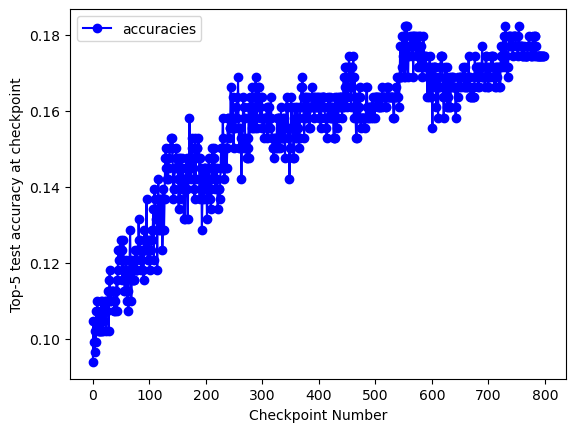

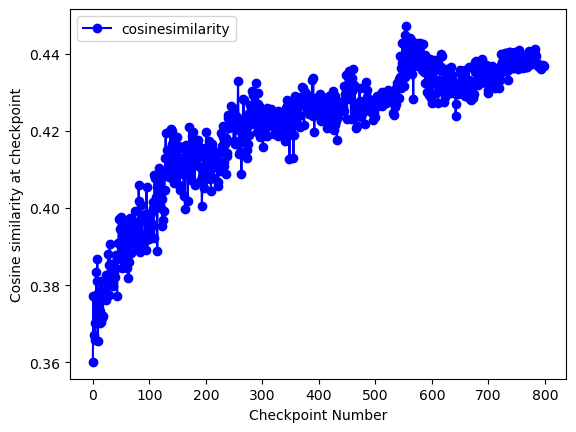

In [4]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(acc_arr, '-o', label = 'accuracies', color = 'blue')
plt.xlabel('Checkpoint Number')
plt.ylabel('Top-5 test accuracy at checkpoint')
plt.legend()
plt.show()

plt.plot(cos_arr, '-o', label = 'cosinesimilarity', color = 'blue')
plt.xlabel('Checkpoint Number')
plt.ylabel('Cosine similarity at checkpoint')
plt.legend()
plt.show()

In [5]:
array_log = open("acc_cos_log.txt", "w")

array_log.write(str(acc_arr))
array_log.write(str("\n\n"))
array_log.write(str(cos_arr))

array_log.close()